In [42]:
# Demo of using Value
from nn_engine.value import Value

In [43]:
def f(x):
    return x ** 2 + 2 * x + 1

# Initialize x with value 3.0 and derivative 1.0
x = Value(3.0)

# Compute f(x)
y = f(x)
y.backward()
print(y)  # Output: Value(value=16.0, derivative=1.0)
print(x) # Output: Value(value=3.0, derivative=8.0)

Value(data=16.0, grad=1.0)
Value(data=3.0, grad=8.0)


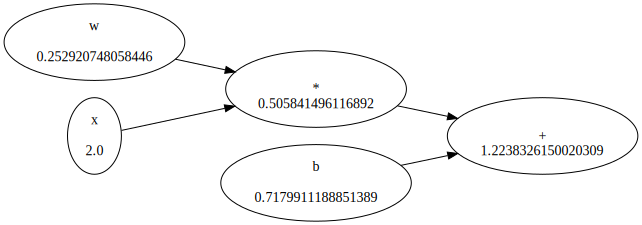

In [44]:
import random
# Define a simple linear model: y = w * x + b
def model(w, b, x):
    return w * x + b

# Define a mean squared error loss function
def loss(y_pred, y_true):
    return (y_pred - y_true) ** 2

# Initialize parameters
w = Value(random.random(), label="w")
b = Value(random.random(), label="b")

# Sample data
x = Value(2.0, label="x")
y_true = 4.0

# Forward pass
y_pred = model(w, b, x)
y_pred.label = "y_pred"
y_pred.graph()

In [45]:
learning_rate = 0.01
for i in range(100):
    y_pred = model(w, b, x)
    current_loss = loss(y_pred, y_true)

    w.grad = 0.0
    b.grad = 0.0
    current_loss.backward()

    w.data -= learning_rate * w.grad
    b.data -= learning_rate * b.grad

print(current_loss)
print(current_loss.data)


Value(data=7.707105349526462, grad=1.0)
5.437423793946921e-09


In [46]:
print(model(w, b, x))

Value(data=3.9999336349996373, grad=0)


In [47]:
#### now implementing the neural network from scratch
import csv
from nn_engine.nn import MLP
import random
import math

In [48]:
# -------------------- Data Loading --------------------
def load_data(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    data = data[:50] # limit to 50 rows for faster result
    random.shuffle(data)
    split = int(0.8 * len(data))
    train = data[:split]
    test = data[split:]
    return train, test

def preprocess(row):
    label = int(row[0])
    pixels = [int(p)/255.0 for p in row[1:]]
    return label, pixels

# -------------------- One-Hot Encoding --------------------

def one_hot(label, num_classes=10):
    vec = [0.0] * num_classes
    vec[label] = 1.0
    return vec

# -------------------- Neural Network --------------------

class SimpleNeuralNetwork:
    def __init__(self, nin, nouts, learning_rate=0.01):
        self.model = MLP(nin, nouts, activation='relu')
        self.lr = learning_rate

    def forward(self, x):
        outputs = self.model(x)
        return outputs

    def compute_loss(self, outputs, target):
        # Cross-entropy loss with softmax (stable)
        max_logit = max(o.data for o in outputs)
        exps = [(o - max_logit).exp() for o in outputs]
        sum_exps = sum(exps)
        softmax = [e / sum_exps for e in exps]
        loss = Value(0.0)
        for s, t in zip(softmax, target):
            loss = loss + (-t) * (s + 1e-8).log()
        return loss

    def backward(self, loss):
        loss.backward()

    def update_parameters(self):
        for p in self.model.parameters():
            p.data -= self.lr * p.grad

    def zero_grad(self):
        self.model.zero_grad()

    def predict(self, x):
        outputs = self.forward(x)
        max_logit = max(o.data for o in outputs)
        exps = [math.exp(o.data - max_logit) for o in outputs]
        sum_exps = sum(exps)
        softmax = [e / sum_exps for e in exps]
        return softmax.index(max(softmax))



In [49]:
# Load data
train, test = load_data('fashion-mnist.csv')
print(f"Training samples: {len(train)}, Test samples: {len(test)}")

# Initialize model
input_size = 784  # 28x28 pixels
hidden_size = 20
output_size = 10  # 10 classes
learning_rate = 0.01
epochs = 5

model = SimpleNeuralNetwork(nin=input_size, nouts=[hidden_size, output_size], learning_rate=learning_rate)

# Train the model
train_model(model, train, epochs=epochs)

# Evaluate the model
evaluate_model(model, test)

Training samples: 40, Test samples: 10
Epoch 1, Step 10, Loss: 15.6384, Accuracy: 0.00%
Epoch 1, Step 20, Loss: 14.8012, Accuracy: 0.00%
Epoch 1, Step 30, Loss: 13.4777, Accuracy: 3.33%
